In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import bz2
import urllib
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
#pip install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline
data_folder = 'data/'

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1076)>


In [2]:
#pip install pyarrow
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [4]:
def matching(df):
    # Separate the treatment and control groups
    treatment_df = df[df['party_Democratic'] == 1]
    control_df = df[df['party_Democratic'] == 0]

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():

            # Calculate the similarity 
            similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])
            if (similarity > 0.75):

            # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.iloc[matched]
    return balanced_df

In [5]:
def logreg(df):
    df = pd.get_dummies(df,columns = ['gender','party'])
    df['age'] = (df['age'] - df['age'].mean())/df['age'].std()
    
    mod = smf.logit(formula='party_Democratic ~  C(gender_female) + age', data=df)

    res = mod.fit()

    # Extract the estimated propensity scores
    df['Propensity_score'] = res.predict()
    print(res.summary())

    return df

In [6]:
def clean_df(df):
    df = df[df['party'].notna()].copy()#supp les None
    df = df[df['age'].notna()].copy() #supp les None
    
    df.party = df.party.str[0] # on garde que le premier parti politique         
        
    print(df['party'].value_counts()) #--> permet de voir les occurences de chaque parti : 
                                      # bcp plus de Republicains et Démocrates = on néglige le reste
        
    df.party.loc[df['party'].str.contains('Democratic')] = 'Democratic'
    df.party.loc[df['party'].str.contains('Republican')] = 'Republican'
    df = df.loc[(df['party'].str.contains('Democratic')) | \
                df['party'].str.contains('Republican')].copy() #uniquement Dem et Rep
    
    df = df.reset_index()
    return df

In [7]:
def sentiment_analysis(df):
    sid = SentimentIntensityAnalyzer()
    df['sentiment'] = df.quotation.apply(sid.polarity_scores)
    df['sentiment'] = df.sentiment.apply(dict.values)
    df['sentiment'] = df.sentiment.apply(list)
    df['sentiment'] = df.sentiment.str[-1]
    return df

In [21]:
def process_chunk(chunk):
    print(f'Processing chunk with {len(chunk)} rows')
    df = chunk.copy()
    df = clean_df(df)
    df = logreg(df)
    balanced_df = matching(df)
    balanced_df = sentiment_analysis(balanced_df)
    
    return balanced_df.reset_index(), df.reset_index()

In [37]:
with pd.read_json(data_folder + 'quotes-2017-extended.json.bz2', lines=True, compression='bz2', chunksize=3000) as df_reader:
    iter_ = 0
    for chunk in df_reader:
        iter_ +=1 
        [balanced_df, df] = process_chunk(chunk)
        if iter_ > 0:
            break

Processing chunk with 3000 rows
Republican Party                                615
Democratic Party                                539
Minnesota Democratic–Farmer–Labor Party          13
independent politician                           12
Conservative Party of New York State              5
Conservative Party                                5
Liberty Union Party                               5
California Republican Party                       5
Peace and Freedom Party                           3
Republican Party of Arkansas                      3
Labour Party                                      2
California Democratic Party                       2
Republican Party of Minnesota                     2
Nebraska Democratic Party                         2
Republican Party of Iowa                          1
People's Party for Freedom and Democracy          1
Liberal Party of Canada                           1
Independence Party of Minnesota                   1
Michigan Republican Party       

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value i

Text(0.5, 0, 'group')

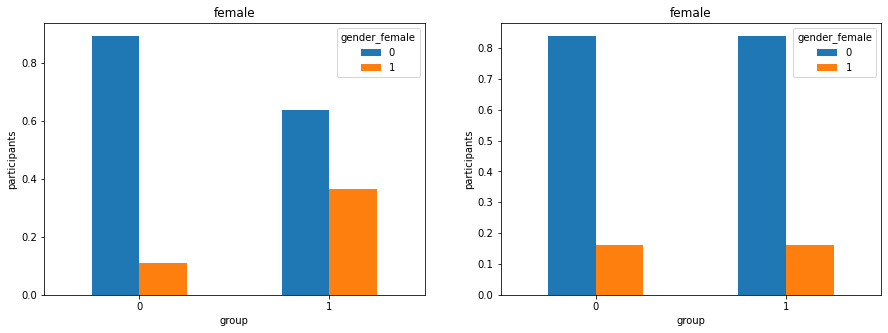

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)
group = df.groupby(['party_Democratic', 'gender_female'])['gender_female'].count()
group = group.unstack()
group = group.div(group.sum(axis=1), axis=0)
pl = group.plot(kind='bar', figsize=[15,5], rot=0, ax = ax1)
pl.set_title('female')
pl.set_ylabel('participants')
pl.set_xlabel('group')

group = balanced_df.groupby(['party_Democratic', 'gender_female'])['gender_female'].count()
group = group.unstack()
group = group.div(group.sum(axis=1), axis=0)
pl = group.plot(kind='bar', figsize=[15,5], rot=0, ax = ax2)
pl.set_title('female')
pl.set_ylabel('participants')
pl.set_xlabel('group')

In [35]:
display(balanced_df)

,level_0,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,...,occupation,age,ethnic_group,religion,gender_female,gender_male,party_Democratic,party_Republican,Propensity_score,sentiment
0,73,204,2017-06-09-104537,"The fastest cure for every social ill, from gu...",Darrell L. Clarke,[Q5224664],2017-06-09 04:00:00,1,"[[Darrell L. Clarke, 0.7825], [None, 0.2175]]",[http://www.phillytrib.com/news/city-oic-team-...,...,[politician],1.431652,None,None,0,1,1,0,0.370959,-0.7184
1,3,9,2017-03-14-098444,"They ask for money. I said, `I don't have any ...",Kim Kardashian,[Q186304],2017-03-14 19:40:45,1,"[[Kim Kardashian, 0.8586], [None, 0.1414]]",[http://feeds.inquisitr.com/~r/google/yDYq/~3/...,...,"[fashion designer, socialite, model, blogger, ...",-1.823828,"[Armenian American, Dutch American, English Am...",[Christianity],1,0,1,0,0.732495,-0.1531
2,352,904,2017-10-09-067210,It's not the firearm that's the problem; it's ...,Ira Hansen,[Q6066080],2017-10-09 21:20:36,1,"[[Ira Hansen, 0.8686], [None, 0.1314]]",[http://mynews4.com/news/local/democratic-legi...,...,[politician],-0.196088,None,None,0,1,0,1,0.381976,-0.4019
3,196,496,2017-11-14-127555,This is not normal. Terrifying scenes of viole...,Gabrielle Giffords,[Q193703],2017-11-14 08:00:00,1,"[[Gabrielle Giffords, 0.6179], [None, 0.3821]]",[http://www.chicoer.com/general-news/20171114/...,...,"[politician, businessperson, entrepreneur, ana...",-1.009958,None,[Judaism],1,0,1,0,0.727871,-0.8403
4,264,660,2017-05-25-049991,If you are a young individual who wants to be ...,Gov. John Bel Edwards,[Q6221385],2017-05-25 18:20:47,1,"[[Gov. John Bel Edwards, 0.8247], [None, 0.166...",[http://www.slate.com/articles/news_and_politi...,...,"[lawyer, politician]",-0.684410,None,None,0,1,1,0,0.385306,0.2716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,341,865,2017-06-11-029315,I'll shoot you if you try and come at me with ...,Aaron Carter,[Q301818],2017-06-11 16:19:18,1,"[[Aaron Carter, 0.9235], [None, 0.067], [Justi...",[http://www.billboard.com/node/7825765],...,"[actor, singer-songwriter, singer, television ...",-2.474924,None,None,0,1,0,1,0.397604,0.0258
270,101,270,2017-05-24-030563,"He's been killed, and apparently nothing serio...",Newt Gingrich,[Q182788],2017-05-24 00:26:18,2,"[[Newt Gingrich, 0.7969], [None, 0.1802], [Set...",[http://www.wnd.com/2017/05/big-list-of-people...,...,"[politician, novelist, writer, teacher, histor...",1.187491,None,[Catholicism],0,1,0,1,0.372603,-0.8744
271,232,585,2017-12-06-154676,"We felt that we had evidence of a murder case,",George Gascon,[Q5539636],2017-12-06 01:35:00,2,"[[George Gascon, 0.6783], [None, 0.3218]]",[http://pleasantonweekly.com/news/2017/12/05/d...,...,[lawyer],0.292234,None,None,0,1,1,0,0.378658,-0.6908
272,342,866,2017-10-26-068500,"I'm no stranger to gun violence here,",John Linder,"[Q1626247, Q6244868]",2017-10-26 04:00:00,1,"[[John Linder, 0.4131], [None, 0.3767], [Dave ...",[http://www.delcotimes.com/general-news/201710...,...,"[politician, military officer, dentist, presid...",1.268878,None,None,0,1,0,1,0.372055,-0.8271


count    392.000000
mean      -0.292904
std        0.539601
min       -0.992800
25%       -0.784500
50%       -0.381800
75%        0.051600
max        0.981700
Name: sentiment, dtype: float64 count    452.000000
mean      -0.241727
std        0.554828
min       -0.987400
25%       -0.728950
50%       -0.340000
75%        0.153100
max        0.934800
Name: sentiment, dtype: float64


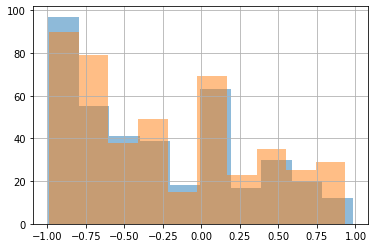

In [39]:
rep_sent = balanced_df.sentiment[df['party_Democratic']==0]
dem_sent = balanced_df.sentiment[df['party_Democratic']==1]
dem_sent.hist(alpha = 0.5)
rep_sent.hist(alpha = 0.5)
print(dem_sent.describe(),rep_sent.describe())